# Packages installation

In [ ]:
#install packages needed if necessary
#!pip install matplotlib
#!pip install particles

# Importations

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from numpy import log

import seaborn as sb
import scipy.stats as stats
from scipy.special import logsumexp

# Modules from particles
import particles 
from particles import distributions as dists

# A word about what we are trying to achieve

Generally, for the type of problems we are speaking about, we deal with:
- An hidden variable $X_t$ that follows a markov process. This variable can be multivariate. It is characterized by a **transition kernel**.
- An observed variable $Y_t$ whose distribution depends on $X_t$. It is characterized by an **emission law**. 

The basic task is, given that we *know* the transition kernel, the emission law, and all their parameters, to recover the $X_t$ based on a sequence of $Y_t$ (*filtering* / *complete smoothing*).

A more challening tasks is to perform **bayesian inference**, that is, to estimate the posterior of the parameters given the data (and prior on the parameters). This task relies on particle MCMC algorithms. 

In our setting: 

- $X$ is composed of 
    - $u_t$, the expression level. It is the variable that, in real life, researchers are trying to recover. 
    - $s_t$, the local scaling term. A variable that follows a markov process independently from everything else and will be useful at some point. 
    - We might even add $a_t$ and $x_t$
- $Y$ is simply $y_t$, the read counts. It is basically **a noisy observation of $u_t$**. Its distribution is described by the **emission law** that involves $u_t$ and $s_t$. 

## What we have to do 

Given the level of complexity of the model, our assignment has changed. We can focus on:

1. **Creating the model**
    - Having a working subclass of Feynman Kac 
    - Being able to generate data (should not be too hard)

2. **Generating some data**

3. **Using the bootstrap filter**

4. **Using the PMMH algorithm to perform some bayesian inference**

## How we are going to do it 

Since our model is pretty complicated, the previous approach subclassing (ssm.StateSpaceModel) will not work. 
Instead, we are going to define ourselves a Feynman-Kac model as explained here: 
https://particles-sequential-monte-carlo-in-python.readthedocs.io/en/latest/notebooks/Defining_Feynman-Kac_models_manually.html

- In the method M, we are going to define a way to sample from our X
    - And we use a function to do so, in order to use it as well when generating the data
- In the method logG, we are going to compute the loglikelihood 

!Note that xp and x are tables containing N particle (we will have to loop throught them)

In [95]:
# The simple example of a feynman-kac model from the package

class GaussianProb(particles.FeynmanKac):
    def __init__(self, a=0., b=1., T=10):
        self.a, self.b, self.T = a, b, T

    def M0(self, N):
        return stats.norm.rvs(size=N)

    def M(self, t, xp):
        return stats.norm.rvs(loc=xp, size=xp.shape)

    def logG(self, t, xp, x):
        return np.where((x < self.b) & (x > self.a), 0., -np.inf)

## Various notes and tips

- We can further simplify the model if it is too complicated
- We could use **numba** (a package) to make the loops run faster
- Compute the loglikelihood, not the likelihood. When we have to sum likelihood, it is always possible to use the log_sum_exp trick (even if I am not absolutely sure that it will be necessary in our case). 
- Simulate the data using parameter's value that make sens (look in the articles) or go looking for a datasource (the Parseq module might have some)
- For the initial law, find it in the paper or use something that makes sens


## Choice regarding the drifts
The explanations in the supplementary materials are unclear. What we are chosing to do is:

**Upward drift**

$u_{t+1} = u_t + Z, \quad Z \sim \mathcal{E}(\frac{\lambda_u}{u_t})$

**Downward drift**

$u_{t+1} = u_t - Z, \quad Z \sim \mathcal{E}(\frac{\lambda_d}{u_t})$

**In both cases, the exponential is parametrized by its RATE** (whereas the numpy funciton works in terms of scale)

**Be wary of the parametrization of the gamma distribution !**
- The gamma class from particles.dists uses a RATE parameter b (a SCALE parameter 1/b)
- In the supplementary materials, they are using a SCALE theta !

## Regarding the emission law

**We have two definitions of it**
- The first will be useful to generate the data 
- The second will be useful to compute the likelihood (we can truncate the sum at 10 or 30)

**Other tips**
- Likelihod of a truncated negative binomial: compute it the usual way, then divide by (1 - probability of 0)
- Poisson law truncated in 0: keep generating until you gave a non-zero value

## Regarding the multiple parameters of the model

It's easy to get lost in the multiplicity of the parameters. Here is a summary of the **16 parameters**

### For the kernle of u_t
- For when $u_t = 0 \quad$ eta, zeta ($\eta,\zeta$)
- For when $u_t >0$
  - Outside of the drifts: alpha, beta, beta_0 ($\alpha, \beta, \beta_0$) 
  - In the drift: gamma_u, gamma_d, lambda_u, lambda_d ($\gamma_u, \gamma_d, \lambda_u, \lambda_d$)

### For the kernel of s_t
- alpha_s, kappa_s ($\alpha_s, \kappa_s$)

### For the emission law (y_t)

- Probabilities: epsilon_b, epsilon_0 ($\epsilon_b, \epsilon_0$)
- Others: kappa, theta, b ($\kappa, \theta, b$)

### Values that make sens

See table S2 in the supplementary materials (p17).
**Except for b**, which we might have to chose. b is a particular case, because in the supplmentary material it is said that " in practice b is set to max(*y*)". But in our case, we need it to generate our data, so BEFORE we have any y. From figure 3 of the article, it seems that setting b = 10 would be a reasonnable choice.
There is no $\epsilon_b$ in the table, but there is an $\epsilon$ so we guess they are the same. 


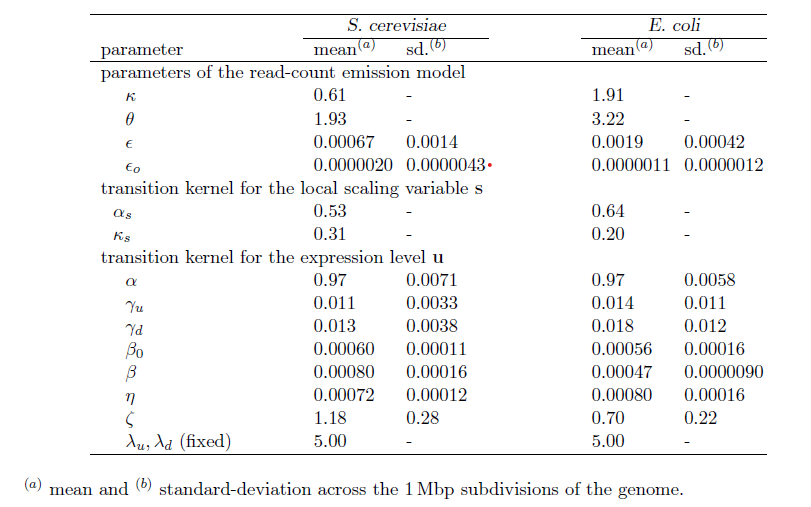

<h1 align = "center"> TO DO </h1>

### Search for an issue in data generation ? 

### Test the boostrap filter and see what is the output of alg

# 1 - Defining data genration and the Feynman-Kac model 

In [2]:
def stepX(xp, 
          eta, alpha, zeta, beta, beta_0, 
          gamma_u, gamma_d, lambda_u, lambda_d,
          alpha_s, kappa_s):
    """
    Performs a step of the kernel
    """
    # xp[0] is u_t
    # xp[1] is s_t
    # The same holds for x
    
    rng = np.random.default_rng(12345) #A numpy generator 
    
    x = np.zeros(shape = (2))
    
    # Computations for u_t
    uniu = dists.Uniform(a = 0., b = 1.).rvs(size = 1) # Uniform to "choose a move"
        
    if xp[0] == 0 :
        if uniu <= eta:
            # Dirac on xp = 0 
            x[0] = 0
        else:
            # Exponential law with rate zeta 
            x[0] = rng.exponential(scale = 1 / zeta, size = 1)
            
    elif xp[0] !=0:
        if uniu <= alpha:
            # Dirac on xp
            x[0] = xp[0]

        elif uniu <= alpha + beta:
            # Exponential law with rate zeta 
            x[0] = rng.exponential(scale = 1 / zeta, size = 1)

        elif uniu <= alpha + beta + beta_0:
            # Dirac on 0
            x[0] = 0

        elif uniu <= alpha + beta + beta_0 + gamma_u:
            # Drift upward (rate lambda_u/xp[0])
            x[0] = xp[0] + rng.exponential(scale = xp[0]/lambda_u, size = 1)

        else:
            # Drift downward (rate lambda_d/xp[0])
            x[0] = xp[0] - rng.exponential(scale = xp[0]/lambda_d, size = 1)
        
        
    # Computations for s_t
    unis = dists.Uniform(a = 0., b = 1.).rvs(size = 1) # Uniform to "choose" a move 
               
    if unis <= alpha_s:
        x[1] = xp[1]
    else:
        x[1] = dists.Gamma(a = kappa_s, b = kappa_s).rvs(size = 1)
        
    return x 

    
def sampleY(x, kappa, theta, epsilon_b, epsilon_0, b):
    """
    Samples an observation y_t based on the vector x_t and some parameters
    Uses the 1st expression of the emission model 
    """
    
    # Sample the number of molecules initially sampled (x_t)
    x_t = dists.Poisson(rate = x[0]*x[1]/(kappa*theta)).rvs(size = 1)
                           
    # Sample the amplificaiton coefficient (a_t)
    a_t = dists.Gamma(kappa, 1/theta).rvs(size = 1) #1/theta
                       
    # Sample the read counts (y_t)
    uniy = dists.Uniform(a = 0., b = 1.).rvs(size = 1) # Uniform to "choose a move"
    
    # With proba "1 - epsilon_b - epsilon_0"
    if uniy < 1 - epsilon_b - epsilon_0:
        y = dists.Poisson(rate = x_t*a_t).rvs(size = 1)
    
    # With proba "epsilon_b"
    elif uniy < 1 - epsilon_0:
        # Generate following a Poisson distribution truncated in 0               
        proposition = 0 
        while proposition == 0:
            proposition = dists.Poisson(rate = 1*a_t).rvs(size = 1)
        y = proposition
                       
    # With proba "epsilon_0"
    else:
        y = dists.DiscreteUniform(0, b+1) # In the supplementary materials, they stae that b should be equal to max(y)
                                          # so we have to do a choice here
    return y 

In [3]:
def generate_data(length, 
                  eta, alpha, zeta, beta, beta_0, 
                  gamma_u, gamma_d, lambda_u, lambda_d,
                  alpha_s, kappa_s,
                  kappa, theta, epsilon_0, epsilon_b, b):
    """
    Function that allows to generate data (that we can then analyze)
    length  is the length of the data to be generated
    """
    
    # Initialisation 
    X = np.zeros(shape = (length, 2))
    Y = np.zeros(shape = length)
    
    # Time = 0
    X[0, :] = np.array([0,0]) # Initial law chosen to be 0
    Y[0] = sampleY(X[0,:], kappa = kappa, theta = theta, epsilon_b = epsilon_b, epsilon_0 = epsilon_0, b = b)
    
    # Time = 1, ...., length 
    for time in range(1, length):
        
        # Update X (one kernel step)
        X[time, :] = stepX(X[time - 1, :], 
                        eta = eta, alpha = alpha, zeta = zeta, beta = beta, beta_0 = beta_0, 
                        gamma_u = gamma_u, gamma_d=gamma_d, lambda_u = lambda_u, lambda_d = lambda_d,
                        alpha_s = alpha_s, kappa_s = kappa_s)
    
        # Sample from Y|X (from the law og Y given X)
        Y[time] = sampleY(X[time,:], kappa =kappa, theta = theta, epsilon_b = epsilon_b, epsilon_0 = epsilon_0, b = b)
    
    return X, Y

A slight uncertainty about the use of parameter "loc" in the scipy.ADIST.logpmf function calls

In [22]:
class RnaProb(particles.FeynmanKac):
    
    def __init__(self, 
                 data_observed,
                 T,
                 sum_truncation = 10,
                 eta =7.2e-4, alpha=0.97, zeta=1.18, beta=8e-4, beta_0=6e-4, 
                 gamma_u=0.011, gamma_d=0.013, lambda_u=5.0, lambda_d=5.0,
                 alpha_s=0.53, kappa_s=0.31,
                 kappa=0.61, theta=1.93, epsilon_0=2e-6, epsilon_b=6.7e-4, b = 10):
        
        # The observed data ie the y_t
        self.data_observed = data_observed
        # The length of the data
        self.T = T
        # The truncation for the infinite sum in the likelihood
        self.sum_truncation = sum_truncation
        
        self.eta = eta 
        self.alpha = alpha
        self.zeta = zeta 
        self.beta = beta 
        self.beta_0 = beta_0 
        
        self.gamma_u = gamma_u 
        self.gamma_d = gamma_d 
        self.lambda_u = lambda_d 
        self.lambda_d = lambda_d
        
        self.alpha_s = alpha_s 
        self.kappa_s = kappa_s
        
        self.kappa = kappa 
        self.theta = theta 
        self.epsilon_0 = epsilon_0
        self.epsilon_b = epsilon_b 
        self.b = b 

        
    def M0(self, N): # N particles 
        return np.zeros(shape = (N,2)) # Initial law chosen to be 0
    
    def M(self, t, xp):
                 
        # Initialize empty vector
        # It has two columns, one for u_t and one for s_t
        x = np.zeros(shape = xp.shape) 
        N = xp.shape[0]
        
        # Loop over the particles
        for i in range(N):
            # Call the function that does one move using the kernel of x
            x[i,:] = stepX(xp[i,:], 
                          eta = self.eta, alpha = self.alpha, zeta = self.zeta, beta = self.beta, beta_0 = self.beta_0, 
                          gamma_u = self.gamma_u, gamma_d = self.gamma_d, lambda_u = self.lambda_u, lambda_d = self.lambda_d,
                          alpha_s = self.alpha_s, kappa_s = self.kappa_s) 
            
        return x
    
                 
    def logG(self, t, xp, x):
        
        # We wish to compute the log of the conditional likelihood, which involves 3 terms
        # We compute the log of each term, then we use the logsumexp funciton
        # In here, data_observed[t] corresponds to y_t
        
        # AND we wish to do so for each of the N particles, hence the looop 
        # MAYBE vectorization would be possible ? --> probably given the x appears only ONCE int the computation
        
        N = x.shape[0] # The number of particles is the first dimension of the array x
        
        NlogGs = np.zeros(N) #Initizaling the empty vector of log probabilities
        
        for i in range(N):
            
            # 1st term - Truncated infinite sum

            # Computation of the log of the terms in the sum
            summation_terms = np.zeros(self.sum_truncation)
            for x_t in range(0, self.sum_truncation):
                summation_terms[x_t] =  stats.poisson.logpmf(k = x_t, mu=x[i,0]*x[i,1]/(self.kappa * self.theta)) + \
                    stats.nbinom.logpmf(k = self.data_observed[t], n = self.kappa, p = 1 - (self.theta*x_t /(1+self.theta*x_t)))

            # Computation of the log of the sum (+ the log of the coefficient in front)
            term_1 = log(1 - self.epsilon_b - self.epsilon_0) + logsumexp(summation_terms)

            # 2nd term - NB truncated in 0
            # Beware the formulations of the NB. Given in the article they state its mean is rp/(1-p)
            # and in scipy it says r(1 -p')/p', we will use p' = 1-p

            term_2 = log(self.epsilon_b) + \
                stats.nbinom.logpmf(k = self.data_observed[t], n = self.kappa, p = 1 - (self.theta /(1+self.theta))) + \
                stats.nbinom.logpmf(k = 0, n = self.kappa, p = 1 - (self.theta /(1+self.theta)))


            # 3rd term - Uniform 
            term_3 = log(self.epsilon_0) + log(1/(self.b+1))
            
            # Final computation
            NlogGs[i] = logsumexp(np.array([term_1, term_2, term_3]))
        
        return NlogGs
        

# 2 - Generating data

In [17]:
# Actual generation of data 
T = 100
# We use the same parameters that inside the Feynman-Kac models 

data_X, data_Y  = generate_data(length = T, 
              eta =7.2e-4, alpha=0.97, zeta=1.18, beta=8e-4, beta_0=6e-4, 
              gamma_u=0.011, gamma_d=0.013, lambda_u=5.0, lambda_d=5.0,
              alpha_s=0.53, kappa_s=0.31,
              kappa=0.61, theta=1.93, epsilon_0=2e-6, epsilon_b=6.7e-4, b = 10)

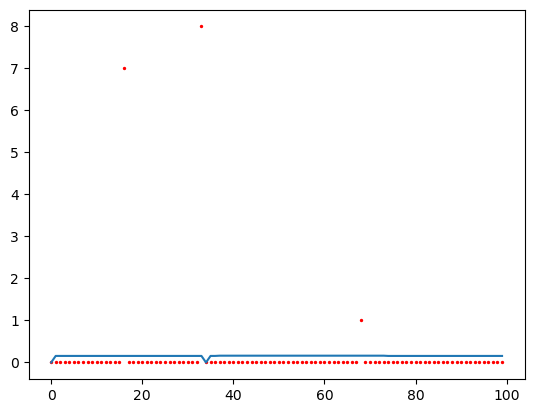

In [18]:
plt.scatter([i for i in range(T)], data_Y, s = 2, color = "red")
plt.plot(data_X[:,0])

# It seems there is a differnce of scale betwwen u_t and s_t which is weird

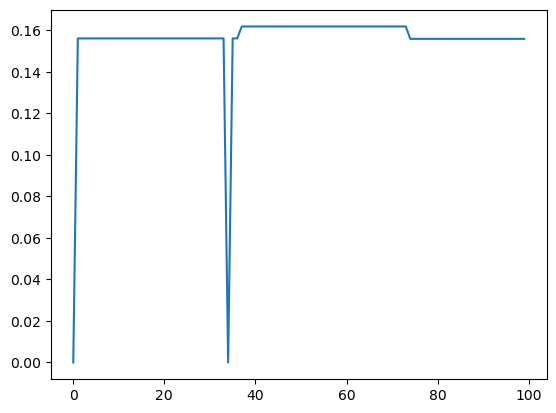

In [19]:
plt.plot(data_X[:,0])

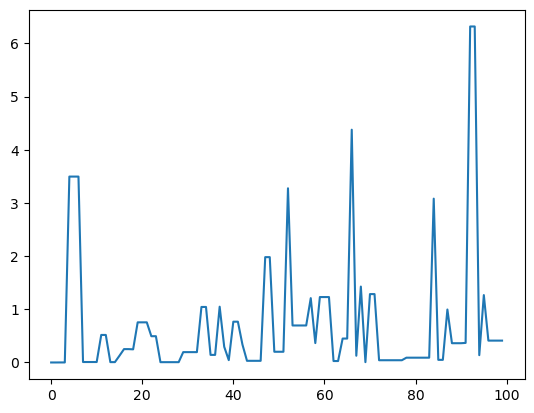

In [20]:
plt.plot(data_X[:,1])

# 2 - Particle filter

In [23]:
fk_rna = RnaProb(data_observed = data_Y, T = T)
alg = particles.SMC(fk = fk_rna, N = 100)
alg.run()
# Slow but works ! 

# 3 - PMMH